# **Data Wrangling & Pre-processing: Predictive Maintenance of Water Pump Systems**

* **Group 9:** Aktham Almomani
* **Course:** Data Analytics and Internet of Things (AAI-530-04)/ University Of San Diego
* **Semester:** Spring 2025

<center>
    <img src="https://github.com/akthammomani/AI_powered_heart_disease_risk_assessment_app/assets/67468718/2cab2215-ce7f-4951-a43a-02b88a5b9fa9" alt="wrnagling">
</center>

## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Dataset](#Dataset)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
  * [Helper functions](#Helper_Functions)
* [Importing the dataset](#Importing_the_dataset)
* [Dataset Cleaning](#Dataset_Cleaning)
  * [Sensor columns Renaming](#Sensor_columns_Renaming)
  * [timestamp datatype](#timestamp_datatype)
  * [Missing Data](#missing_data)
  * [Selecting Key Sensors for Machine Health Monitoring](#Selecting_Sensors)
  * [Renaming Selected Sensors for Clarity](#Renaming_Sensors)
  * [Original Machine Status Field](#Original_Machine_Status)
* [Features Engineering](#Features_Engineering)
  * [New Machine Status Field](#New_Machine_Status)
  * [Machine Health Flags](#Machine_Health_Flags)
  * [Failure Category](#Failure_Category)
  * [Failure Cause](#Failure_Cause)
  * [Affected Sensors List](#Affected_Sensors_List)
* [Saving the cleaned dataframe](#Saving_the_cleaned_dataframe)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

In this notebook, we're getting our dataset in shape before any analysis. The focus is on **data wrangling and preprocessing** to make sure everything is clean, structured, and ready for insights.  

**What We'll Be Doing**:  

* **Cleaning the data**: Making sure everything is formatted correctly, handling missing values, and keeping only useful sensors.  

* **Preprocessing for analysis**: Converting timestamps, renaming columns, and standardizing sensor readings.  

* **Feature engineering**: Building smart features like **machine health flags, failure categories, and failure causes** to help us detect issues faster.  

By the end, we'll have a **clean, structured dataset** that makes it easy to track and predict the health of our machine

## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

The dataset we'll be using is called "Pump Sensor Data" and is available on [Kaggle](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/data). This dataset provides real-world IoT sensor data collected from water pump systems.

**Data Collection**: The data was gathered from sensors installed in water pump systems. These sensors monitor a wide range of parameters such as motor and pump vibrations, frequencies, power usage, and bearing temperatures. The collection process spans over time, capturing changes in system behavior and helping identify operational issues or equipment failures.

**Dataset Overview**:
* Number of Observations: The dataset contains 220,320 entries.
* Number of Variables: There are 55 columns, including 52 numerical variables (sensor readings), one timestamp column, and one categorical column representing machine status

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [11]:
#Let's import the necessary packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# let's run below to customize notebook display:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

# format floating-point numbers to 2 decimal places:
pd.set_option('float_format', '{:.2f}'.format)

### **Helper functions**<a id='Helper_Functions'></a>
[Contents](#Contents)

In [2]:
def summarize_df(df):
    """
    Generate a summary DataFrame for an input DataFrame:
      - 'unique_count': No. unique values in each column.
      - 'data_types': Data types of each column.
      - 'missing_counts': No. of missing (NaN) values in each column.
      - 'missing_percentage': Percentage of missing values in each column.
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()
    # Data types of each column:
    data_types = df.dtypes
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)
    # Rename the columns for better readibility:
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']
    # Return summary df:
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts:
    counts = df[column_name].value_counts(dropna=False)

    # Calculate percentages:
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100

    # Combine into a DataFrame and reset index:
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    }).rename_axis(None).reset_index()

    # Rename the first column to match the original column name:
    result.rename(columns={'index': column_name}, inplace=True)

    return result
#-----------------------------------------------------------------------------------------------------------------#
def dynamic_impute(df, threshold=0.1):
    """
    Impute missing values dynamically based on the gap between mean and median.
    """
    # Get sensor columns:
    sensor_columns = [col for col in df.columns if col.startswith('snr')]

    for col in sensor_columns:
        mean_val = df[col].mean()
        median_val = df[col].median()

        # Calculate percentage difference:
        diff = abs(mean_val - median_val) / mean_val

        # Imputation decision:
        if diff <= threshold:
            # Mean and median are close, use the mean:
            df[col] = df[col].fillna(mean_val)
            print(f"Imputed '{col}' using mean (diff = {diff:.2%})")
        elif median_val > mean_val:
            # Median is significantly higher, use the median:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median because median > mean (diff = {diff:.2%})")
        else:
            # Use median for any other skewed cases:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median (diff = {diff:.2%})")

    return df


## **Importing the dataset**<a id='Importing_the_dataset'></a>
[Contents](#Contents)

Since I'm using google colab, let's mount the driver:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#First, let's load the main dataset sensor: (https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/data)
df = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/sensor.csv',
    index_col=0
)

In [5]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 220320 
Number of columns: 54


In [12]:
# Now, let's look at the top 5 rows of the df:
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,NaN,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,243.06,201.39,NORMAL
1,2018-04-01 00:01:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,NaN,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,243.06,201.39,NORMAL
2,2018-04-01 00:02:00,2.44,47.35,53.21,46.40,638.89,73.55,13.32,16.04,15.62,15.01,37.87,48.18,32.09,1.71,420.85,NaN,462.78,459.64,2.50,666.22,399.94,880.42,501.36,982.73,631.13,740.80,849.90,454.24,778.57,715.63,661.57,721.88,694.77,441.26,169.98,343.20,200.97,93.91,41.41,31.25,69.53,30.47,31.77,41.67,39.35,65.39,51.22,38.19,155.96,67.13,241.32,203.70,NORMAL
3,2018-04-01 00:03:00,2.46,47.09,53.17,46.40,628.12,76.99,13.32,16.25,15.70,15.08,38.58,48.66,31.67,1.58,420.75,NaN,462.90,460.89,2.51,666.01,399.10,878.89,499.04,977.75,625.41,739.27,847.76,474.87,779.51,690.40,686.11,754.69,683.38,446.25,166.50,343.96,193.17,101.04,41.93,31.51,72.14,30.47,31.51,40.89,39.06,64.81,51.22,38.19,155.96,66.84,240.45,203.12,NORMAL
4,2018-04-01 00:04:00,2.45,47.14,53.21,46.40,636.46,76.59,13.35,16.21,15.70,15.08,39.49,49.06,31.95,1.68,419.89,NaN,461.49,468.22,2.60,663.21,400.54,882.59,498.54,979.58,627.18,737.60,846.92,408.82,785.23,704.69,631.48,766.15,702.44,433.91,164.75,339.96,193.88,101.70,42.71,31.51,76.82,30.99,31.51,41.41,38.77,65.10,51.79,38.77,158.28,66.55,242.19,201.39,NORMAL


## **Dataset Cleaning**<a id='Dataset_Cleaning'></a>
[Contents](#Contents)

* First, let's make sure no white space.
* **Sensor column names**: The names are just numbers (`sensor_01`, `sensor_02`, etc.). We should check the dataset documentation to see if better names are available and rename the sensors accordingly.
* **`timestamp` column**: Right now, it's an object (string). We'll convert it to `datetime` to make it easier for time-based analysis.

* **Missing data**: All sensor columns have some missing values, so we need to handle that.
  * **`sensor_15`** is completely empty (100% missing). It's useless, so it should go.
  * **`sensor_50`** has a lot of missing values (about 35%). We'll probably drop it too. Before deciding to drop it, let's first check its purpose or role in the dataset.
* **Selecting key sensors**: Not all sensors are equally important. We will focus on the most relevant ones for machine health monitoring.
* **Renaming selected sensors**: Clearer names make it easier to interpret the data, so we will rename the selected sensors based on their function.  
* **Dropping the original machine status**: The provided machine status isn't always reliable, so we'll be building a more accurate version. Once that's in place, we'll remove the original column.


In [7]:
# Alright, now, let's make sure no white space in the dataset, so if any will be replaced with NAN:
df.replace("", np.nan, inplace=True)

In [8]:
# Here's, let's call our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,object,0,0.00
sensor_00,1253,float64,10208,4.63
sensor_01,831,float64,369,0.17
sensor_02,831,float64,19,0.01
sensor_03,588,float64,19,0.01
sensor_04,7844,float64,19,0.01
sensor_05,190751,float64,19,0.01
sensor_06,812,float64,4798,2.18
sensor_07,531,float64,5451,2.47
sensor_08,626,float64,5107,2.32


In [9]:
# alright, now let's look if there's any duplicate values:
num_duplicates = df['timestamp'].duplicated().sum()
print(f"Number of duplicate rows based on 'timestamp': {num_duplicates}")

Number of duplicate rows based on 'timestamp': 0


Alright, this is good. No duplicates in the dataset!

### **Sensor columns Renaming**<a id='Sensor_columns_Renaming'></a>
[Contents](#Contents)

Before renaming the columns, let's cross-check the names provided [here](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/discussion/131429) with the statistics of each sensor to ensure they align and provide better clarity:

* SENSOR_00 - Motor Casing Vibration
* SENSOR_01 - Motor Frequency A
* SENSOR_02 - Motor Frequency B
* SENSOR_03 - Motor Frequency C
* SENSOR_04 - Motor Speed
* SENSOR_05 - Motor Current
* SENSOR_06 - Motor Active Power
* SENSOR_07 - Motor Apparent Power
* SENSOR_08 - Motor Reactive Power
* SENSOR_09 - Motor Shaft Power  
* SENSOR_10 - Motor Phase Current A
* SENSOR_11 - Motor Phase Current B
* SENSOR_12 - Motor Phase Current C
* SENSOR_13 - Motor Coupling Vibration
* SENSOR_14 - Motor Phase Voltage AB
* SENSOR_16 - Motor Phase Voltage BC
* SENSOR_17 - Motor Phase Voltage CA
* SENSOR_18 - Pump Casing Vibration
* SENSOR_19 - Pump Stage 1 Impeller Speed
* SENSOR_20 - Pump Stage 1 Impeller Speed
* SENSOR_21 - Pump Stage 1 Impeller Speed
* SENSOR_22 - Pump Stage 1 Impeller Speed
* SENSOR_23 - Pump Stage 1 Impeller Speed
* SENSOR_24 - Pump Stage 1 Impeller Speed
* SENSOR_25 - Pump Stage 2 Impeller Speed
* SENSOR_26 - Pump Stage 2 Impeller Speed
* SENSOR_27 - Pump Stage 2 Impeller Speed
* SENSOR_28 - Pump Stage 2 Impeller Speed
* SENSOR_29 - Pump Stage 2 Impeller Speed
* SENSOR_30 - Pump Stage 2 Impeller Speed
* SENSOR_31 - Pump Stage 2 Impeller Speed
* SENSOR_32 - Pump Stage 2 Impeller Speed
* SENSOR_33 - Pump Stage 2 Impeller Speed
* SENSOR_34 - Pump Inlet Flow
* SENSOR_35 - Pump Discharge Flow
* SENSOR_36 - Pump UNKNOWN
* SENSOR_37 - Pump Lube Oil Overhead Reservoir Level
* SENSOR_38 - Pump Lube Oil Return Temp
* SENSOR_39 - Pump Lube Oil Supply Temp
* SENSOR_40 - Pump Thrust Bearing Active Temp
* SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
* SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
* SENSOR_43 - Pump Thrust Bearing Inactive Temp
* SENSOR_44 - Pump Drive End Radial Bearing Temp 1
* SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
* SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
* SENSOR_47 - Pump Drive End Radial Bearing Temp 2
* SENSOR_48 - Pump Inlet Pressure
* SENSOR_49 - Pump Temp Unknown
* SENSOR_50 - Pump Discharge Pressure 1
* SENSOR_51 - Pump Discharge Pressure 2




In [13]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.00,219951.00,220301.00,220301.00,220301.00,220301.00,215522.00,214869.00,215213.00,215725.00,220301.00,220301.00,220301.00,220301.00,220299.00,0.00,220289.00,220274.00,220274.00,220304.00,220304.00,220304.00,220279.00,220304.00,220304.00,220284.00,220300.00,220304.00,220304.00,220248.00,220059.00,220304.00,220252.00,220304.00,220304.00,220304.00,220304.00,220304.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,143303.00,204937.00
mean,2.37,47.59,50.87,43.75,590.67,73.40,13.50,15.84,15.20,14.80,41.47,41.92,29.14,7.08,376.86,NaN,416.47,421.13,2.30,590.83,360.81,796.23,459.79,922.61,556.24,649.14,786.41,501.51,851.69,576.20,614.60,863.32,804.28,486.41,234.97,427.13,593.03,60.79,49.66,36.61,68.84,35.37,35.45,43.88,42.66,43.09,48.02,44.34,150.89,57.12,183.05,202.70
std,0.41,3.30,3.67,2.42,144.02,17.30,2.16,2.20,2.04,2.09,12.09,13.06,10.11,6.90,113.21,NaN,126.07,129.16,0.77,199.35,101.97,226.68,154.53,291.84,182.30,220.87,246.66,169.82,313.07,225.76,195.73,283.54,260.60,150.75,88.38,141.77,289.39,37.60,10.54,15.61,21.37,7.90,10.26,11.04,11.58,12.84,15.64,10.44,82.24,19.14,65.26,109.59
min,0.00,0.00,33.16,31.64,2.80,0.00,0.01,0.00,0.03,0.00,0.00,0.00,0.00,0.00,32.41,NaN,0.00,0.00,0.00,0.00,0.00,95.53,0.00,0.00,0.00,0.00,43.15,0.00,4.32,0.64,0.00,23.96,0.24,6.46,54.88,0.00,2.26,0.00,24.48,19.27,23.44,20.83,22.14,24.48,25.75,26.33,26.33,27.20,26.33,26.62,27.49,27.78
25%,2.44,46.31,50.39,42.84,626.62,69.98,13.35,15.91,15.18,15.05,40.71,38.86,28.69,1.54,418.10,NaN,459.45,454.14,2.45,662.77,398.02,875.46,478.96,950.92,601.15,693.96,790.49,448.30,782.68,518.95,627.78,839.06,760.61,489.76,172.49,353.18,288.55,28.80,45.57,32.55,57.81,32.55,32.81,39.58,36.75,36.75,40.51,39.06,83.91,47.74,167.53,179.11
50%,2.46,48.13,51.65,44.23,632.64,75.58,13.64,16.17,15.49,15.08,44.29,45.36,32.52,2.93,420.11,NaN,462.86,462.02,2.53,665.67,399.37,879.70,531.86,981.92,625.87,740.20,861.87,494.47,967.28,564.87,668.98,917.71,878.85,512.27,226.36,473.35,709.67,64.30,49.48,35.42,66.41,34.90,35.16,42.97,40.51,40.22,44.85,42.53,138.02,52.66,193.87,197.34
75%,2.50,49.48,52.78,45.31,637.62,80.91,14.54,16.43,15.70,15.12,47.46,49.66,34.94,12.86,421.00,NaN,464.30,466.86,2.59,667.15,400.09,882.13,534.25,1090.81,628.61,750.36,919.10,536.27,1043.98,744.02,697.22,981.25,943.88,555.16,316.84,528.89,837.33,90.82,53.65,39.06,77.86,37.76,36.98,46.61,45.14,44.85,51.22,46.59,208.33,60.76,219.91,216.72
max,2.55,56.73,56.03,48.22,800.00,100.00,22.25,23.60,24.35,25.00,76.11,60.00,45.00,31.19,500.00,NaN,739.74,600.00,4.87,878.92,448.91,1107.53,594.06,1227.56,1000.00,839.58,1214.42,2000.00,1841.15,1466.28,1600.00,1800.00,1839.21,1578.60,425.55,694.48,984.06,174.90,417.71,547.92,512.76,420.31,374.22,408.59,1000.00,320.31,370.37,303.53,561.63,464.41,1000.00,1000.00


**Observations and Adjustments:**

Based on the data:

* **sensor_00**:
  * **Proposed Name**: Motor Casing Vibration.
  * **Observation**: Small mean and low range suggest vibration. Name is valid.

* **sensor_01, sensor_02, sensor_03**:
  * **Proposed Name**: Motor Frequency A, B, C.
  * **Observation**: Values stay under 60, aligning with frequency in Hz. Names are valid.

* **sensor_04**:
  * **Proposed Name**: Motor Speed (RPM).
  * **Observation**: High values (~590 mean, max 800) fit RPM. Name is valid.

* **sensor_05**:
  * **Proposed Name**: Motor Current.
  * **Observation**: Moderate values (~73 mean, max 99). Likely a current sensor. Name is valid.

* **sensor_06 to sensor_09**:
  * **Proposed Names**: Active, Apparent, Reactive, Shaft Power.
  * **Observation**: Low but consistent values (13 - 15 range). Names are valid.

* **sensor_10 to sensor_12**:
  * **Proposed Names**: Phase Currents (A, B, C).
  * **Observation**: Moderate values (~41 mean, max 76). These align with electrical currents. Names are valid.

* **sensor_13**:
  * **Proposed Name**: Motor Coupling Vibration.
  * **Observation**: Low values (~7 mean, max 31). Fits vibration readings. Name is valid.

* **sensor_14 to sensor_17**:
  * **Proposed Names**: Motor Phase Voltages (AB, BC, CA).
  * **Observation**: High values (~376 - 421 mean, max ~600+). These fit voltage readings. Names are valid.

* **sensor_18**:
  * **Proposed Name**: Pump Casing Vibration.
  * **Observation**: Low range (~2 mean, max ~4). Matches vibration. Name is valid.

* **sensor_19 to sensor_33**:
  * **Proposed Names**: Pump Impeller Speeds (Stage 1 & 2).
  * **Observation**: High and consistent values (~500 - 900 mean, max ~1200). Fits speed sensors. Names are valid.

* **sensor_34 and sensor_35**:
  * **Proposed Names**: Pump Inlet and Discharge Flow.
  * **Observation**: Values (~234 and ~427 mean, max ~500 - 700). Likely flow rates. Names are valid.

* **sensor_36**:
  * **Proposed Name**: Pump UNKNOWN.
  * **Observation**: High range (~593 mean, max ~984). Could be flow or pressure. Let's name this one as 'Pump Auxiliary Flow or Pressure'

* **sensor_37**:
  * **Proposed Name**: Pump Lube Oil Overhead Reservoir Level.
  * **Observation**: Low mean (~60), consistent with a level sensor. Name is valid.

* **sensor_38 to sensor_44**:
  * **Proposed Names**: Pump Lube Oil and Bearing Temperatures.
  * **Observation**: Values (~35 - 68 mean, max ~400). Names are valid.

* **sensor_45 to sensor_49**:
  * **Proposed Names**: Pump Radial Bearing Temperatures.
  * **Observation**: Values (~42 - 57 mean, max ~464). Names are valid.

* **sensor_50 and sensor_51**:
  * **Proposed Names**: Pump Discharge Pressures (1 & 2).
  * **Observation**: High values (~183 - 202 mean, max ~1000). Names are valid.


In [14]:
sensor_name_mapping = {
    'sensor_00': 'snr_00_motor_casing_vibration',
    'sensor_01': 'snr_01_motor_frequency_a',
    'sensor_02': 'snr_02_motor_frequency_b',
    'sensor_03': 'snr_03_motor_frequency_c',
    'sensor_04': 'snr_04_motor_speed',
    'sensor_05': 'snr_05_motor_current',
    'sensor_06': 'snr_06_motor_active_power',
    'sensor_07': 'snr_07_motor_apparent_power',
    'sensor_08': 'snr_08_motor_reactive_power',
    'sensor_09': 'snr_09_motor_shaft_power',
    'sensor_10': 'snr_10_motor_phase_current_a',
    'sensor_11': 'snr_11_motor_phase_current_b',
    'sensor_12': 'snr_12_motor_phase_current_c',
    'sensor_13': 'snr_13_motor_coupling_vibration',
    'sensor_14': 'snr_14_motor_phase_voltage_ab',
    'sensor_15': 'snr_15_PH',  # missed 100% will be dropped
    'sensor_16': 'snr_16_motor_phase_voltage_bc',
    'sensor_17': 'snr_17_motor_phase_voltage_ca',
    'sensor_18': 'snr_18_pump_casing_vibration',
    'sensor_19': 'snr_19_pump_stage_1_impeller_speed',
    'sensor_20': 'snr_20_pump_stage_1_impeller_speed',
    'sensor_21': 'snr_21_pump_stage_1_impeller_speed',
    'sensor_22': 'snr_22_pump_stage_1_impeller_speed',
    'sensor_23': 'snr_23_pump_stage_1_impeller_speed',
    'sensor_24': 'snr_24_pump_stage_1_impeller_speed',
    'sensor_25': 'snr_25_pump_stage_2_impeller_speed',
    'sensor_26': 'snr_26_pump_stage_2_impeller_speed',
    'sensor_27': 'snr_27_pump_stage_2_impeller_speed',
    'sensor_28': 'snr_28_pump_stage_2_impeller_speed',
    'sensor_29': 'snr_29_pump_stage_2_impeller_speed',
    'sensor_30': 'snr_30_pump_stage_2_impeller_speed',
    'sensor_31': 'snr_31_pump_stage_2_impeller_speed',
    'sensor_32': 'snr_32_pump_stage_2_impeller_speed',
    'sensor_33': 'snr_33_pump_stage_2_impeller_speed',
    'sensor_34': 'snr_34_pump_inlet_flow',
    'sensor_35': 'snr_35_pump_discharge_flow',
    'sensor_36': 'snr_36_pump_auxiliary_flow_or_pressure',
    'sensor_37': 'snr_37_pump_lube_oil_overhead_reservoir_level',
    'sensor_38': 'snr_38_pump_lube_oil_return_temp',
    'sensor_39': 'snr_39_pump_lube_oil_supply_temp',
    'sensor_40': 'snr_40_pump_thrust_bearing_active_temp',
    'sensor_41': 'snr_41_motor_non_drive_end_radial_bearing_temp_1',
    'sensor_42': 'snr_42_motor_non_drive_end_radial_bearing_temp_2',
    'sensor_43': 'snr_43_pump_thrust_bearing_inactive_temp',
    'sensor_44': 'snr_44_pump_drive_end_radial_bearing_temp_1',
    'sensor_45': 'snr_45_pump_non_drive_end_radial_bearing_temp_1',
    'sensor_46': 'snr_46_pump_non_drive_end_radial_bearing_temp_2',
    'sensor_47': 'snr_47_pump_drive_end_radial_bearing_temp_2',
    'sensor_48': 'snr_48_pump_inlet_pressure',
    'sensor_49': 'snr_49_pump_temp_unknown',
    'sensor_50': 'snr_50_pump_discharge_pressure_1',# since i have 2 sensors with pressure "sensor_50 & sensor_51" I will be dropping sensor_50 since it has ~35% missing data
    'sensor_51': 'snr_51_pump_discharge_pressure'
}

# Alright, now let's apply the mapping
df.rename(columns=sensor_name_mapping, inplace=True)


In [15]:
df.head()

,timestamp,snr_00_motor_casing_vibration,snr_01_motor_frequency_a,snr_02_motor_frequency_b,snr_03_motor_frequency_c,snr_04_motor_speed,snr_05_motor_current,snr_06_motor_active_power,snr_07_motor_apparent_power,snr_08_motor_reactive_power,snr_09_motor_shaft_power,snr_10_motor_phase_current_a,snr_11_motor_phase_current_b,snr_12_motor_phase_current_c,snr_13_motor_coupling_vibration,snr_14_motor_phase_voltage_ab,snr_15_PH,snr_16_motor_phase_voltage_bc,snr_17_motor_phase_voltage_ca,snr_18_pump_casing_vibration,snr_19_pump_stage_1_impeller_speed,snr_20_pump_stage_1_impeller_speed,snr_21_pump_stage_1_impeller_speed,snr_22_pump_stage_1_impeller_speed,snr_23_pump_stage_1_impeller_speed,snr_24_pump_stage_1_impeller_speed,snr_25_pump_stage_2_impeller_speed,snr_26_pump_stage_2_impeller_speed,snr_27_pump_stage_2_impeller_speed,snr_28_pump_stage_2_impeller_speed,snr_29_pump_stage_2_impeller_speed,snr_30_pump_stage_2_impeller_speed,snr_31_pump_stage_2_impeller_speed,snr_32_pump_stage_2_impeller_speed,snr_33_pump_stage_2_impeller_speed,snr_34_pump_inlet_flow,snr_35_pump_discharge_flow,snr_36_pump_auxiliary_flow_or_pressure,snr_37_pump_lube_oil_overhead_reservoir_level,snr_38_pump_lube_oil_return_temp,snr_39_pump_lube_oil_supply_temp,snr_40_pump_thrust_bearing_active_temp,snr_41_motor_non_drive_end_radial_bearing_temp_1,snr_42_motor_non_drive_end_radial_bearing_temp_2,snr_43_pump_thrust_bearing_inactive_temp,snr_44_pump_drive_end_radial_bearing_temp_1,snr_45_pump_non_drive_end_radial_bearing_temp_1,snr_46_pump_non_drive_end_radial_bearing_temp_2,snr_47_pump_drive_end_radial_bearing_temp_2,snr_48_pump_inlet_pressure,snr_49_pump_temp_unknown,snr_50_pump_discharge_pressure_1,snr_51_pump_discharge_pressure,machine_status
0,2018-04-01 00:00:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,NaN,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,243.06,201.39,NORMAL
1,2018-04-01 00:01:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,NaN,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,243.06,201.39,NORMAL
2,2018-04-01 00:02:00,2.44,47.35,53.21,46.40,638.89,73.55,13.32,16.04,15.62,15.01,37.87,48.18,32.09,1.71,420.85,NaN,462.78,459.64,2.50,666.22,399.94,880.42,501.36,982.73,631.13,740.80,849.90,454.24,778.57,715.63,661.57,721.88,694.77,441.26,169.98,343.20,200.97,93.91,41.41,31.25,69.53,30.47,31.77,41.67,39.35,65.39,51.22,38.19,155.96,67.13,241.32,203.70,NORMAL
3,2018-04-01 00:03:00,2.46,47.09,53.17,46.40,628.12,76.99,13.32,16.25,15.70,15.08,38.58,48.66,31.67,1.58,420.75,NaN,462.90,460.89,2.51,666.01,399.10,878.89,499.04,977.75,625.41,739.27,847.76,474.87,779.51,690.40,686.11,754.69,683.38,446.25,166.50,343.96,193.17,101.04,41.93,31.51,72.14,30.47,31.51,40.89,39.06,64.81,51.22,38.19,155.96,66.84,240.45,203.12,NORMAL
4,2018-04-01 00:04:00,2.45,47.14,53.21,46.40,636.46,76.59,13.35,16.21,15.70,15.08,39.49,49.06,31.95,1.68,419.89,NaN,461.49,468.22,2.60,663.21,400.54,882.59,498.54,979.58,627.18,737.60,846.92,408.82,785.23,704.69,631.48,766.15,702.44,433.91,164.75,339.96,193.88,101.70,42.71,31.51,76.82,30.99,31.51,41.41,38.77,65.10,51.79,38.77,158.28,66.55,242.19,201.39,NORMAL


Ok, now the column names are much more meaningful and easier to understand.

### **timestamp datatype**<a id='timestamp_datatype'></a>
[Contents](#Contents)

In [16]:
# Alright, let's fix up 'timestamp' to be datetime:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [17]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,datetime64[ns],0,0.00
snr_00_motor_casing_vibration,1253,float64,10208,4.63
snr_01_motor_frequency_a,831,float64,369,0.17
snr_02_motor_frequency_b,831,float64,19,0.01
snr_03_motor_frequency_c,588,float64,19,0.01
snr_04_motor_speed,7844,float64,19,0.01
snr_05_motor_current,190751,float64,19,0.01
snr_06_motor_active_power,812,float64,4798,2.18
snr_07_motor_apparent_power,531,float64,5451,2.47
snr_08_motor_reactive_power,626,float64,5107,2.32


### **Missing Data**<a id='missing_data'></a>
[Contents](#Contents)

* **Missing data**: All sensor columns have some missing values, so we need to handle that. Also:
  * **`sensor_15`** is completely empty (100% missing). It's useless, so it should go.
  * **`sensor_50`** has a lot of missing values (~35%). We'll probably drop it too.

In [18]:
# Alright, let's drop 'snr_15_PH' and 'snr_50_pump_discharge_pressure_1' since we don't need them:
df = df.drop(columns=['snr_15_PH', 'snr_50_pump_discharge_pressure_1'], errors='ignore')

In [19]:
# Alright, let's take a look at the stats to decide, mean or median imputation:
df.describe()

,timestamp,snr_00_motor_casing_vibration,snr_01_motor_frequency_a,snr_02_motor_frequency_b,snr_03_motor_frequency_c,snr_04_motor_speed,snr_05_motor_current,snr_06_motor_active_power,snr_07_motor_apparent_power,snr_08_motor_reactive_power,snr_09_motor_shaft_power,snr_10_motor_phase_current_a,snr_11_motor_phase_current_b,snr_12_motor_phase_current_c,snr_13_motor_coupling_vibration,snr_14_motor_phase_voltage_ab,snr_16_motor_phase_voltage_bc,snr_17_motor_phase_voltage_ca,snr_18_pump_casing_vibration,snr_19_pump_stage_1_impeller_speed,snr_20_pump_stage_1_impeller_speed,snr_21_pump_stage_1_impeller_speed,snr_22_pump_stage_1_impeller_speed,snr_23_pump_stage_1_impeller_speed,snr_24_pump_stage_1_impeller_speed,snr_25_pump_stage_2_impeller_speed,snr_26_pump_stage_2_impeller_speed,snr_27_pump_stage_2_impeller_speed,snr_28_pump_stage_2_impeller_speed,snr_29_pump_stage_2_impeller_speed,snr_30_pump_stage_2_impeller_speed,snr_31_pump_stage_2_impeller_speed,snr_32_pump_stage_2_impeller_speed,snr_33_pump_stage_2_impeller_speed,snr_34_pump_inlet_flow,snr_35_pump_discharge_flow,snr_36_pump_auxiliary_flow_or_pressure,snr_37_pump_lube_oil_overhead_reservoir_level,snr_38_pump_lube_oil_return_temp,snr_39_pump_lube_oil_supply_temp,snr_40_pump_thrust_bearing_active_temp,snr_41_motor_non_drive_end_radial_bearing_temp_1,snr_42_motor_non_drive_end_radial_bearing_temp_2,snr_43_pump_thrust_bearing_inactive_temp,snr_44_pump_drive_end_radial_bearing_temp_1,snr_45_pump_non_drive_end_radial_bearing_temp_1,snr_46_pump_non_drive_end_radial_bearing_temp_2,snr_47_pump_drive_end_radial_bearing_temp_2,snr_48_pump_inlet_pressure,snr_49_pump_temp_unknown,snr_51_pump_discharge_pressure
count,220320,210112.00,219951.00,220301.00,220301.00,220301.00,220301.00,215522.00,214869.00,215213.00,215725.00,220301.00,220301.00,220301.00,220301.00,220299.00,220289.00,220274.00,220274.00,220304.00,220304.00,220304.00,220279.00,220304.00,220304.00,220284.00,220300.00,220304.00,220304.00,220248.00,220059.00,220304.00,220252.00,220304.00,220304.00,220304.00,220304.00,220304.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,220293.00,204937.00
mean,2018-06-16 11:59:29.999999488,2.37,47.59,50.87,43.75,590.67,73.40,13.50,15.84,15.20,14.80,41.47,41.92,29.14,7.08,376.86,416.47,421.13,2.30,590.83,360.81,796.23,459.79,922.61,556.24,649.14,786.41,501.51,851.69,576.20,614.60,863.32,804.28,486.41,234.97,427.13,593.03,60.79,49.66,36.61,68.84,35.37,35.45,43.88,42.66,43.09,48.02,44.34,150.89,57.12,202.70
min,2018-04-01 00:00:00,0.00,0.00,33.16,31.64,2.80,0.00,0.01,0.00,0.03,0.00,0.00,0.00,0.00,0.00,32.41,0.00,0.00,0.00,0.00,0.00,95.53,0.00,0.00,0.00,0.00,43.15,0.00,4.32,0.64,0.00,23.96,0.24,6.46,54.88,0.00,2.26,0.00,24.48,19.27,23.44,20.83,22.14,24.48,25.75,26.33,26.33,27.20,26.33,26.62,27.78
25%,2018-05-09 05:59:45,2.44,46.31,50.39,42.84,626.62,69.98,13.35,15.91,15.18,15.05,40.71,38.86,28.69,1.54,418.10,459.45,454.14,2.45,662.77,398.02,875.46,478.96,950.92,601.15,693.96,790.49,448.30,782.68,518.95,627.78,839.06,760.61,489.76,172.49,353.18,288.55,28.80,45.57,32.55,57.81,32.55,32.81,39.58,36.75,36.75,40.51,39.06,83.91,47.74,179.11
50%,2018-06-16 11:59:30,2.46,48.13,51.65,44.23,632.64,75.58,13.64,16.17,15.49,15.08,44.29,45.36,32.52,2.93,420.11,462.86,462.02,2.53,665.67,399.37,879.70,531.86,981.92,625.87,740.20,861.87,494.47,967.28,564.87,668.98,917.71,878.85,512.27,226.36,473.35,709.67,64.30,49.48,35.42,66.41,34.90,35.16,42.97,40.51,40.22,44.85,42.53,138.02,52.66,197.34
75%,2018-07-24 17:59:15,2.50,49.48,52.78,45.31,637.62,80.91,14.54,16.43,15.70,15.12,47.46,49.66,34.94,12.86,421.00,464.30,466.86,2.59,667.15,400.09,882.13,534.25,1090.81,628.61,750.36,919.10,536.27,1043.98,744.02,697.22,981.25,943.88,555.16,316.84,528.89,837.33,90.82,53.65,39.06,77.86,37.76,36.98,46.61,45.14,44.85,51.22,46.59,208.33,60.76,216.72
max,2018-08-31 23:59:00,2.55,56.73,56.03,48.22,800.00,100.00,22.25,23.60,24.35,25.00,76.11,60.00,45.00,31.19,500.00,739.74,600.0

In [20]:
# Alright, let's focus only on the sensor columns and check the mean vs. median difference:
sensor_columns = [col for col in df.columns if col.startswith('snr')]

for col in sensor_columns:
    mean_val = round(df[col].mean(), 2)
    median_val = round(df[col].median(), 2)
    print(f"{col}: Mean = {mean_val}, Median = {median_val}")

snr_00_motor_casing_vibration: Mean = 2.37, Median = 2.46
snr_01_motor_frequency_a: Mean = 47.59, Median = 48.13
snr_02_motor_frequency_b: Mean = 50.87, Median = 51.65
snr_03_motor_frequency_c: Mean = 43.75, Median = 44.23
snr_04_motor_speed: Mean = 590.67, Median = 632.64
snr_05_motor_current: Mean = 73.4, Median = 75.58
snr_06_motor_active_power: Mean = 13.5, Median = 13.64
snr_07_motor_apparent_power: Mean = 15.84, Median = 16.17
snr_08_motor_reactive_power: Mean = 15.2, Median = 15.49
snr_09_motor_shaft_power: Mean = 14.8, Median = 15.08
snr_10_motor_phase_current_a: Mean = 41.47, Median = 44.29
snr_11_motor_phase_current_b: Mean = 41.92, Median = 45.36
snr_12_motor_phase_current_c: Mean = 29.14, Median = 32.52
snr_13_motor_coupling_vibration: Mean = 7.08, Median = 2.93
snr_14_motor_phase_voltage_ab: Mean = 376.86, Median = 420.11
snr_16_motor_phase_voltage_bc: Mean = 416.47, Median = 462.86
snr_17_motor_phase_voltage_ca: Mean = 421.13, Median = 462.02
snr_18_pump_casing_vibration:

In [21]:
# Alright, let's dynamically impute the missing values: if the difference between mean and median for sensor columns is high then use median if it's low then use mean:
df = dynamic_impute(df, threshold=0.1)

Imputed 'snr_00_motor_casing_vibration' using mean (diff = 3.55%)
Imputed 'snr_01_motor_frequency_a' using mean (diff = 1.14%)
Imputed 'snr_02_motor_frequency_b' using mean (diff = 1.54%)
Imputed 'snr_03_motor_frequency_c' using mean (diff = 1.09%)
Imputed 'snr_04_motor_speed' using mean (diff = 7.10%)
Imputed 'snr_05_motor_current' using mean (diff = 2.97%)
Imputed 'snr_06_motor_active_power' using mean (diff = 1.05%)
Imputed 'snr_07_motor_apparent_power' using mean (diff = 2.05%)
Imputed 'snr_08_motor_reactive_power' using mean (diff = 1.93%)
Imputed 'snr_09_motor_shaft_power' using mean (diff = 1.91%)
Imputed 'snr_10_motor_phase_current_a' using mean (diff = 6.80%)
Imputed 'snr_11_motor_phase_current_b' using mean (diff = 8.22%)
Imputed 'snr_12_motor_phase_current_c' using median because median > mean (diff = 11.60%)
Imputed 'snr_13_motor_coupling_vibration' using median (diff = 58.61%)
Imputed 'snr_14_motor_phase_voltage_ab' using median because median > mean (diff = 11.48%)
Impute

In [22]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,datetime64[ns],0,0.00
snr_00_motor_casing_vibration,1254,float64,0,0.00
snr_01_motor_frequency_a,832,float64,0,0.00
snr_02_motor_frequency_b,832,float64,0,0.00
snr_03_motor_frequency_c,589,float64,0,0.00
snr_04_motor_speed,7845,float64,0,0.00
snr_05_motor_current,190752,float64,0,0.00
snr_06_motor_active_power,813,float64,0,0.00
snr_07_motor_apparent_power,532,float64,0,0.00
snr_08_motor_reactive_power,627,float64,0,0.00


In [23]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 220320 
Number of columns: 52


Awesome, there're no more missing data and also we managed to keep dataset size as is.

In [24]:
df.head()

,timestamp,snr_00_motor_casing_vibration,snr_01_motor_frequency_a,snr_02_motor_frequency_b,snr_03_motor_frequency_c,snr_04_motor_speed,snr_05_motor_current,snr_06_motor_active_power,snr_07_motor_apparent_power,snr_08_motor_reactive_power,snr_09_motor_shaft_power,snr_10_motor_phase_current_a,snr_11_motor_phase_current_b,snr_12_motor_phase_current_c,snr_13_motor_coupling_vibration,snr_14_motor_phase_voltage_ab,snr_16_motor_phase_voltage_bc,snr_17_motor_phase_voltage_ca,snr_18_pump_casing_vibration,snr_19_pump_stage_1_impeller_speed,snr_20_pump_stage_1_impeller_speed,snr_21_pump_stage_1_impeller_speed,snr_22_pump_stage_1_impeller_speed,snr_23_pump_stage_1_impeller_speed,snr_24_pump_stage_1_impeller_speed,snr_25_pump_stage_2_impeller_speed,snr_26_pump_stage_2_impeller_speed,snr_27_pump_stage_2_impeller_speed,snr_28_pump_stage_2_impeller_speed,snr_29_pump_stage_2_impeller_speed,snr_30_pump_stage_2_impeller_speed,snr_31_pump_stage_2_impeller_speed,snr_32_pump_stage_2_impeller_speed,snr_33_pump_stage_2_impeller_speed,snr_34_pump_inlet_flow,snr_35_pump_discharge_flow,snr_36_pump_auxiliary_flow_or_pressure,snr_37_pump_lube_oil_overhead_reservoir_level,snr_38_pump_lube_oil_return_temp,snr_39_pump_lube_oil_supply_temp,snr_40_pump_thrust_bearing_active_temp,snr_41_motor_non_drive_end_radial_bearing_temp_1,snr_42_motor_non_drive_end_radial_bearing_temp_2,snr_43_pump_thrust_bearing_inactive_temp,snr_44_pump_drive_end_radial_bearing_temp_1,snr_45_pump_non_drive_end_radial_bearing_temp_1,snr_46_pump_non_drive_end_radial_bearing_temp_2,snr_47_pump_drive_end_radial_bearing_temp_2,snr_48_pump_inlet_pressure,snr_49_pump_temp_unknown,snr_51_pump_discharge_pressure,machine_status
0,2018-04-01 00:00:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,201.39,NORMAL
1,2018-04-01 00:01:00,2.47,47.09,53.21,46.31,634.38,76.46,13.41,16.13,15.57,15.05,37.23,47.52,31.12,1.68,419.57,461.88,466.33,2.57,665.40,398.99,880.00,498.89,975.94,627.67,741.72,848.07,429.04,785.19,684.94,594.44,682.81,680.44,433.70,171.94,341.90,195.07,90.32,40.36,31.51,70.57,30.99,31.77,41.93,39.64,65.68,50.93,38.19,157.99,67.71,201.39,NORMAL
2,2018-04-01 00:02:00,2.44,47.35,53.21,46.40,638.89,73.55,13.32,16.04,15.62,15.01,37.87,48.18,32.09,1.71,420.85,462.78,459.64,2.50,666.22,399.94,880.42,501.36,982.73,631.13,740.80,849.90,454.24,778.57,715.63,661.57,721.88,694.77,441.26,169.98,343.20,200.97,93.91,41.41,31.25,69.53,30.47,31.77,41.67,39.35,65.39,51.22,38.19,155.96,67.13,203.70,NORMAL
3,2018-04-01 00:03:00,2.46,47.09,53.17,46.40,628.12,76.99,13.32,16.25,15.70,15.08,38.58,48.66,31.67,1.58,420.75,462.90,460.89,2.51,666.01,399.10,878.89,499.04,977.75,625.41,739.27,847.76,474.87,779.51,690.40,686.11,754.69,683.38,446.25,166.50,343.96,193.17,101.04,41.93,31.51,72.14,30.47,31.51,40.89,39.06,64.81,51.22,38.19,155.96,66.84,203.12,NORMAL
4,2018-04-01 00:04:00,2.45,47.14,53.21,46.40,636.46,76.59,13.35,16.21,15.70,15.08,39.49,49.06,31.95,1.68,419.89,461.49,468.22,2.60,663.21,400.54,882.59,498.54,979.58,627.18,737.60,846.92,408.82,785.23,704.69,631.48,766.15,702.44,433.91,164.75,339.96,193.88,101.70,42.71,31.51,76.82,30.99,31.51,41.41,38.77,65.10,51.79,38.77,158.28,66.55,201.39,NORMAL


In [25]:
df.describe()

,timestamp,snr_00_motor_casing_vibration,snr_01_motor_frequency_a,snr_02_motor_frequency_b,snr_03_motor_frequency_c,snr_04_motor_speed,snr_05_motor_current,snr_06_motor_active_power,snr_07_motor_apparent_power,snr_08_motor_reactive_power,snr_09_motor_shaft_power,snr_10_motor_phase_current_a,snr_11_motor_phase_current_b,snr_12_motor_phase_current_c,snr_13_motor_coupling_vibration,snr_14_motor_phase_voltage_ab,snr_16_motor_phase_voltage_bc,snr_17_motor_phase_voltage_ca,snr_18_pump_casing_vibration,snr_19_pump_stage_1_impeller_speed,snr_20_pump_stage_1_impeller_speed,snr_21_pump_stage_1_impeller_speed,snr_22_pump_stage_1_impeller_speed,snr_23_pump_stage_1_impeller_speed,snr_24_pump_stage_1_impeller_speed,snr_25_pump_stage_2_impeller_speed,snr_26_pump_stage_2_impeller_speed,snr_27_pump_stage_2_impeller_speed,snr_28_pump_stage_2_impeller_speed,snr_29_pump_stage_2_impeller_speed,snr_30_pump_stage_2_impeller_speed,snr_31_pump_stage_2_impeller_speed,snr_32_pump_stage_2_impeller_speed,snr_33_pump_stage_2_impeller_speed,snr_34_pump_inlet_flow,snr_35_pump_discharge_flow,snr_36_pump_auxiliary_flow_or_pressure,snr_37_pump_lube_oil_overhead_reservoir_level,snr_38_pump_lube_oil_return_temp,snr_39_pump_lube_oil_supply_temp,snr_40_pump_thrust_bearing_active_temp,snr_41_motor_non_drive_end_radial_bearing_temp_1,snr_42_motor_non_drive_end_radial_bearing_temp_2,snr_43_pump_thrust_bearing_inactive_temp,snr_44_pump_drive_end_radial_bearing_temp_1,snr_45_pump_non_drive_end_radial_bearing_temp_1,snr_46_pump_non_drive_end_radial_bearing_temp_2,snr_47_pump_drive_end_radial_bearing_temp_2,snr_48_pump_inlet_pressure,snr_49_pump_temp_unknown,snr_51_pump_discharge_pressure
count,220320,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00,220320.00
mean,2018-06-16 11:59:29.999999488,2.37,47.59,50.87,43.75,590.67,73.40,13.50,15.84,15.20,14.80,41.47,41.92,29.14,7.08,376.86,416.48,421.13,2.30,590.84,360.81,796.23,459.81,922.61,556.24,649.16,786.41,501.51,851.70,576.20,614.60,863.32,804.28,486.41,234.97,427.13,593.04,60.79,49.66,36.61,68.84,35.37,35.45,43.88,42.66,43.09,48.02,44.34,150.89,57.12,202.70
min,2018-04-01 00:00:00,0.00,0.00,33.16,31.64,2.80,0.00,0.01,0.00,0.03,0.00,0.00,0.00,0.00,0.00,32.41,0.00,0.00,0.00,0.00,0.00,95.53,0.00,0.00,0.00,0.00,43.15,0.00,4.32,0.64,0.00,23.96,0.24,6.46,54.88,0.00,2.26,0.00,24.48,19.27,23.44,20.83,22.14,24.48,25.75,26.33,26.33,27.20,26.33,26.62,27.78
25%,2018-05-09 05:59:45,2.42,46.31,50.39,42.84,626.62,69.98,13.35,15.86,15.18,15.01,40.71,38.86,28.69,1.54,418.10,459.45,454.13,2.45,662.77,398.02,875.47,478.97,950.92,601.15,693.97,790.34,448.30,782.69,518.96,627.78,839.06,760.70,489.75,172.49,353.18,288.56,28.80,45.57,32.55,57.81,32.55,32.81,39.58,36.75,36.75,40.51,39.06,83.91,47.74,180.56
50%,2018-06-16 11:59:30,2.46,48.13,51.65,44.23,632.64,75.58,13.63,16.17,15.45,15.08,44.29,45.36,32.52,2.93,420.11,462.86,462.02,2.53,665.67,399.37,879.70,531.86,981.92,625.87,740.20,861.83,494.48,967.28,564.89,668.98,917.71,878.81,512.27,226.37,473.35,709.67,64.29,49.48,35.42,66.41,34.90,35.16,42.97,40.51,40.22,44.85,42.53,138.02,52.66,199.94
75%,2018-07-24 17:59:15,2.50,49.48,52.78,45.31,637.62,80.91,14.54,16.43,15.70,15.12,47.46,49.66,34.94,12.86,421.00,464.30,466.86,2.59,667.15,400.09,882.13,534.25,1090.81,628.61,750.36,919.10,536.27,1043.97,743.95,697.22,981.25,943.86,555.16,316.84,528.89,837.33,90.82,53.65,39.06,77.86,37.76,36.98,46.61,45.14,44.85,51.22,46.59,208.33,60.76,214.70
max,2018-08-31 23:59:00,2.55,56.73,56.03,48.22,800.00,100.00,22.25,23.60,24.35,25.00,76.11,60.00,45.00,31.19,500.00,739.74,600.0

Alright, the dataset spans a 5-month period from April 1, 2018, to August 31, 2018.

### **Selecting Key Sensors for Machine Health Monitoring**<a id='Selecting_Sensors'></a>
[Contents](#Contents)

In industrial applications, sensor data is crucial for monitoring machine health and predicting failures. However, with dozens of available sensors, selecting the most relevant ones is essential for accurate classification while avoiding noise from less impactful signals.

To ensure an optimal selection, we will use a statistical significance approach combined with domain expertise to identify the top 10 sensors that have the most influence on machine status.

In [26]:
# First, let's identify sensor columns:
sensor_columns = [col for col in df.columns if "snr_" in col]

# Compute statistics for each sensor and let's Transpose for better readability:
sensor_stats = df[sensor_columns].describe().T

# Calculate additional metrics:
sensor_stats["range"] = sensor_stats["max"] - sensor_stats["min"]
sensor_stats["std_ratio"] = sensor_stats["std"] / sensor_stats["mean"]

# Display sensor statistics:
sensor_stats_sorted = sensor_stats.sort_values(by="std_ratio", ascending=False)
sensor_stats_sorted

,count,mean,std,min,25%,50%,75%,max,range,std_ratio
snr_13_motor_coupling_vibration,220320.00,7.08,6.90,0.00,1.54,2.93,12.86,31.19,31.19,0.98
snr_37_pump_lube_oil_overhead_reservoir_level,220320.00,60.79,37.60,0.00,28.80,64.29,90.82,174.90,174.90,0.62
snr_48_pump_inlet_pressure,220320.00,150.89,82.24,26.33,83.91,138.02,208.33,561.63,535.30,0.55
snr_51_pump_discharge_pressure,220320.00,202.70,105.69,27.78,180.56,199.94,214.70,1000.00,972.22,0.52
snr_36_pump_auxiliary_flow_or_pressure,220320.00,593.04,289.38,2.26,288.56,709.67,837.33,984.06,981.80,0.49
snr_39_pump_lube_oil_supply_temp,220320.00,36.61,15.61,19.27,32.55,35.42,39.06,547.92,528.65,0.43
snr_29_pump_stage_2_impeller_speed,220320.00,576.20,225.73,0.64,518.96,564.89,743.95,1466.28,1465.64,0.39
snr_34_pump_inlet_flow,220320.00,234.97,88.37,54.88,172.49,226.37,316.84,425.55,370.67,0.38
snr_28_pump_stage_2_impeller_speed,220320.00,851.70,313.06,4.32,782.69,967.28,1043.97,1841.15,1836.83,0.37
snr_12_motor_phase_current_c,220320.00,29.14,10.11,0.00,28.69,32.52,34.94,45.00,45.00,0.35


Now let's visualize all sensors:

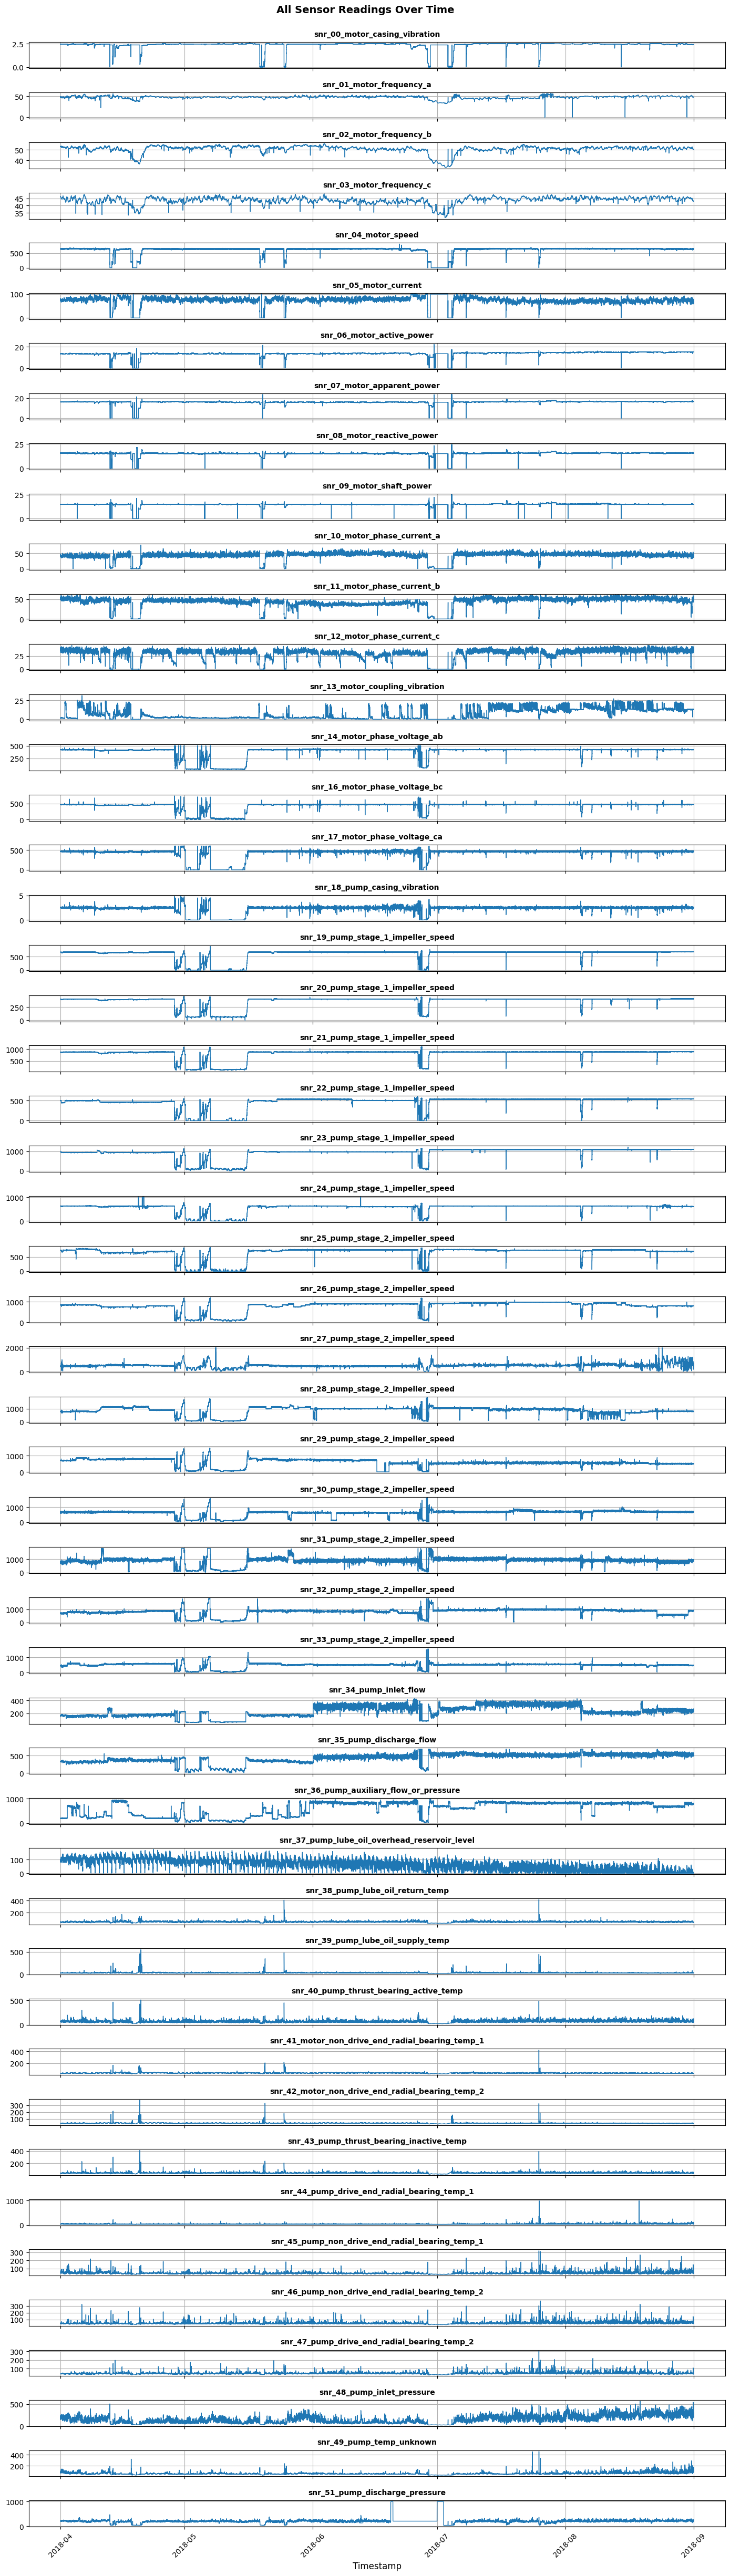

In [27]:
def plot_all_sensors(df, sensors=None, title="All Sensor Readings Over Time"):
    """
    Plots all sensor readings over time as subplots with properly aligned titles
    """

    if sensors is None:
        sensors = [col for col in df.columns if col.startswith("snr_")]  # Auto-detect sensors

    num_sensors = len(sensors)
    fig, axes = plt.subplots(num_sensors, 1, figsize=(14, num_sensors), sharex=True)

    if num_sensors == 1:
        axes = [axes]

    for i, sensor in enumerate(sensors):
        axes[i].plot(df["timestamp"], df[sensor], linewidth=1)
        axes[i].set_title(sensor, fontsize=10, fontweight='bold', pad=8)
        axes[i].grid(True)

    # Formatting:
    axes[-1].set_xlabel("Timestamp", fontsize=12)
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Plot all sensors in the dataset:
plot_all_sensors(df)


**How we picked the Sensors that matter**  

When working with machine data, we don't want to include **every single sensor** that would be inefficient and redundant. Instead, we took a smart, data-driven approach to picking the ones that actually matter.  

**What we considered**  

* **Statistical Significance**  
Not all sensors provide useful signals. Some barely change, while others fluctuate wildly. We checked things like:  
  * **Standard deviation & range**: If a sensor never changes, it's not helpful.  
  * **Variability**: Sensors with meaningful variations over time are key for detecting machine health changes.  

* **Industrial knowledge & vommon sense**  
Some sensors are **more critical** for understanding how the machine is doing. From experience, we know:  
  * **Vibration sensors**: Catch early signs of failure.  
  * **Motor current, power, and speed**: Reflect performance & efficiency.  
  * **Temperature sensors**: Help spot overheating issues.  

* **Avoiding redundant sensors**  
Machines have **a lot** of sensors measuring similar things. For example, if we have 10 temperature sensors but they all show the **same trend**, we don't need all of them. We compared sensor behavior and **kept the most representative ones**.  

* **Visualizing everything**  
We plotted **all sensor data over time** to see which ones actually showed useful trends. If a sensor barely moved or looked exactly like another one, we dropped it.  

**The 10 Sensors We're Keeping**: After all that, here are the **top 10 sensors** that give us the best picture of machine health:  

  * **snr_12_motor_phase_current_c**: Motor current phase C  
  * **snr_09_motor_shaft_power**: Motor shaft power  
  * **snr_04_motor_speed**: Motor speed  
  * **snr_19_pump_stage_1_impeller_speed**: Pump impeller speed  
  * **snr_18_pump_casing_vibration**: Pump casing vibration  
  * **snr_51_pump_discharge_pressure**: Pump discharge pressure  
  * **snr_39_pump_lube_oil_supply_temp**: Lube oil supply temperature  
  * **snr_18_pump_casing_vibration**: (Yes, again! Key vibration metric)  
  * **snr_00_motor_casing_vibration**: Motor casing vibration  
  * **snr_17_motor_phase_voltage_ca**: Motor voltage phase CA  

These sensors cover **electrical, mechanical, and thermal** aspects of the machine, giving us a **well-rounded** view without extra noise.  



In [28]:
# Define the selected sensor columns:
selected_sensors = [
    "snr_12_motor_phase_current_c",
    "snr_09_motor_shaft_power",
    "snr_04_motor_speed",
    "snr_19_pump_stage_1_impeller_speed",
    "snr_18_pump_casing_vibration",
    "snr_51_pump_discharge_pressure",
    "snr_39_pump_lube_oil_supply_temp",
    "snr_00_motor_casing_vibration",
    "snr_17_motor_phase_voltage_ca"
]

# Keep only the selected sensors + timestamp + existing machine status:
df = df[["timestamp", "machine_status"] + selected_sensors]
df.head()

,timestamp,machine_status,snr_12_motor_phase_current_c,snr_09_motor_shaft_power,snr_04_motor_speed,snr_19_pump_stage_1_impeller_speed,snr_18_pump_casing_vibration,snr_51_pump_discharge_pressure,snr_39_pump_lube_oil_supply_temp,snr_00_motor_casing_vibration,snr_17_motor_phase_voltage_ca
0,2018-04-01 00:00:00,NORMAL,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
1,2018-04-01 00:01:00,NORMAL,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
2,2018-04-01 00:02:00,NORMAL,32.09,15.01,638.89,666.22,2.50,203.70,31.25,2.44,459.64
3,2018-04-01 00:03:00,NORMAL,31.67,15.08,628.12,666.01,2.51,203.12,31.51,2.46,460.89
4,2018-04-01 00:04:00,NORMAL,31.95,15.08,636.46,663.21,2.60,201.39,31.51,2.45,468.22


### **Renaming Selected Sensors for Clarity**<a id='Renaming_Sensors'></a>
[Contents](#Contents)

Our sensor names were a bit long and technical, so we're giving them **cleaner, more intuitive names** while keeping their original meanings intact.  

| **Old Sensor Name**                          | **New Sensor Name**                | **Description** |
|----------------------------------------------|------------------------------------|----------------|
| `snr_12_motor_phase_current_c`              | `snr_01_motor_phase_current`       | Measures the electrical current in the motor phase. |
| `snr_09_motor_shaft_power`                  | `snr_02_motor_shaft_power`         | Indicates the power output of the motor shaft. |
| `snr_04_motor_speed`                         | `snr_03_motor_speed`               | Monitors the speed of the motor. |
| `snr_19_pump_stage_1_impeller_speed`        | `snr_04_pump_impeller_speed`       | Tracks the speed of the pump's impeller. |
| `snr_18_pump_casing_vibration`              | `snr_05_pump_casing_vibration`     | Measures vibrations in the pump casing. |
| `snr_51_pump_discharge_pressure`            | `snr_06_pump_discharge_pressure`   | Reads the pressure at the pump's discharge point. |
| `snr_39_pump_lube_oil_supply_temp`          | `snr_07_pump_lube_oil_supply_temp` | Monitors the temperature of lubricating oil. |
| `snr_00_motor_casing_vibration`             | `snr_08_motor_casing_vibration`    | Tracks vibration levels in the motor casing. |
| `snr_17_motor_phase_voltage_ca`             | `snr_09_motor_phase_voltage`       | Measures voltage across motor phases. |

Now, let's apply these new names to our dataset.


In [29]:
# Define mapping of old sensor names to new names:
sensor_rename_map = {
    "snr_12_motor_phase_current_c": "snr_01_motor_phase_current",
    "snr_09_motor_shaft_power": "snr_02_motor_shaft_power",
    "snr_04_motor_speed": "snr_03_motor_speed",
    "snr_19_pump_stage_1_impeller_speed": "snr_04_pump_impeller_speed",
    "snr_18_pump_casing_vibration": "snr_05_pump_casing_vibration",
    "snr_51_pump_discharge_pressure": "snr_06_pump_discharge_pressure",
    "snr_39_pump_lube_oil_supply_temp": "snr_07_pump_lube_oil_supply_temp",
    "snr_00_motor_casing_vibration": "snr_08_motor_casing_vibration",
    "snr_17_motor_phase_voltage_ca": "snr_09_motor_phase_voltage"
}

# Rename the columns in the filtered dataframe:
df = df.rename(columns=sensor_rename_map)

df.head()

,timestamp,machine_status,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage
0,2018-04-01 00:00:00,NORMAL,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
1,2018-04-01 00:01:00,NORMAL,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
2,2018-04-01 00:02:00,NORMAL,32.09,15.01,638.89,666.22,2.50,203.70,31.25,2.44,459.64
3,2018-04-01 00:03:00,NORMAL,31.67,15.08,628.12,666.01,2.51,203.12,31.51,2.46,460.89
4,2018-04-01 00:04:00,NORMAL,31.95,15.08,636.46,663.21,2.60,201.39,31.51,2.45,468.22


In [30]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 220320 
Number of columns: 11


In [31]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,datetime64[ns],0,0.00
machine_status,3,object,0,0.00
snr_01_motor_phase_current,187145,float64,0,0.00
snr_02_motor_shaft_power,566,float64,0,0.00
snr_03_motor_speed,7845,float64,0,0.00
snr_04_pump_impeller_speed,100422,float64,0,0.00
snr_05_pump_casing_vibration,152604,float64,0,0.00
snr_06_pump_discharge_pressure,1109,float64,0,0.00
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.00
snr_08_motor_casing_vibration,1254,float64,0,0.00


### **Original Machine Status Field**<a id='Original_Machine_Status'></a>
[Contents](#Contents)

Before we rely on the dataset's **machine status** field, we need to ask: **"Is it actually accurate?"** If the labels are incorrect or inconsistent, any analysis or model we build will be unreliable.  

**How we'll investigate**  

We'll compare the **existing machine status** with what the selected sensors tell us. Specifically, we will:  
* **Check distribution**: Are the labels balanced, or do they seem off?  
* **Plot trends**: Does the machine status match sensor readings over time?  
* **Find contradictions**: Are there cases where the machine is labeled as "Normal" while critical sensors show major anomalies?  

If we see clear **mismatches**, we'll **redefine machine status** using a **data-driven** approach based on the 10 key sensors we selected earlier.  

In [32]:
value_counts_with_percentage(df, 'machine_status')

,machine_status,Count,Percentage
0,NORMAL,205836,93.43
1,RECOVERING,14477,6.57
2,BROKEN,7,0.00


**Summary Highlights**


* **Way Too Many Normal Cases**: A whopping 93.43 percent of the data is labeled as Normal. That is suspicious. Machines do not just run perfectly all the time.   

* **Barely Any Broken Cases**: Only 7 instances 0.00 percent are marked as Broken. Either this machine is invincible or the dataset is not catching failures properly.  

* **Recovering Without Broken**: We have got 14477 cases of Recovering but only 7 Broken. How does something recover if it never breaks That is like healing from an injury you never had.  

The current machine status labels are off. If we rely on them any predictive model we build will be flawed. alright, let's try to fix it

let's verify the accuracy of the machine status!!

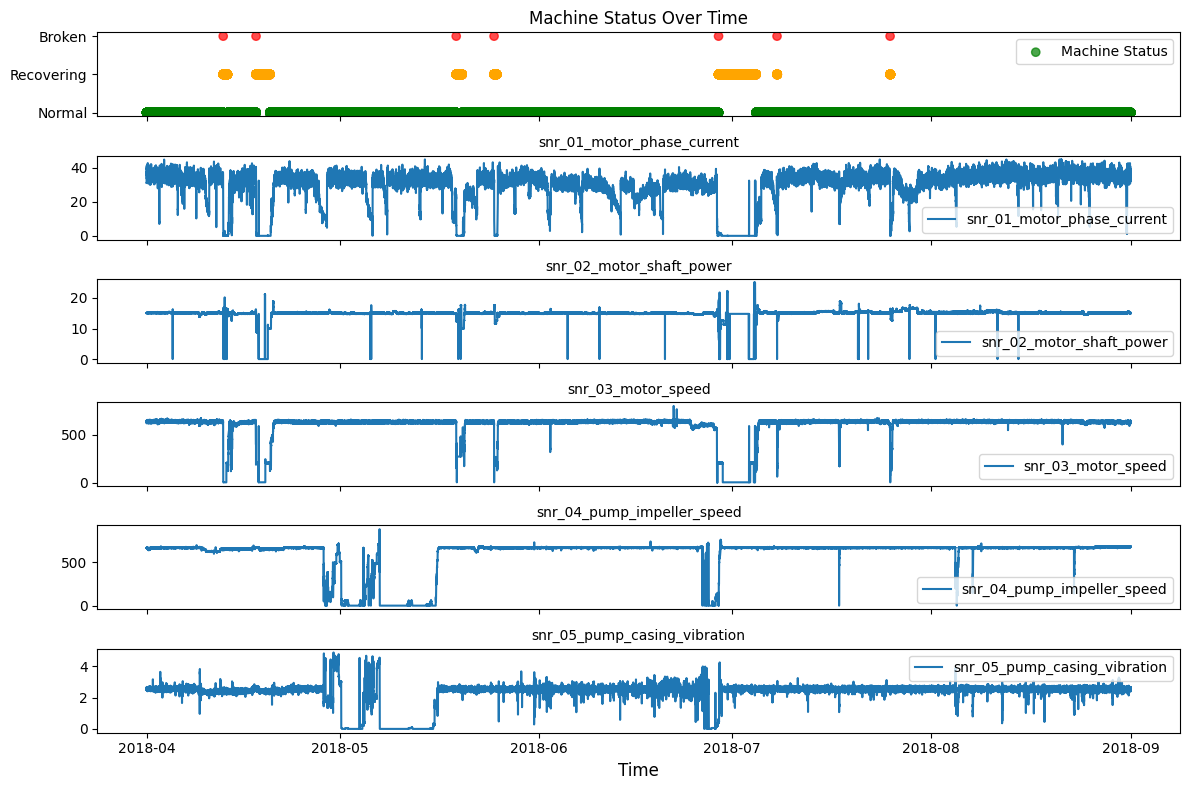

In [33]:
# Select key sensors for comparison:
key_sensors = [
    "snr_01_motor_phase_current",
    "snr_02_motor_shaft_power",
    "snr_03_motor_speed",
    "snr_04_pump_impeller_speed",
    "snr_05_pump_casing_vibration"
]

# Ensure machine status is in a valid format:
df["machine_status"] = df["machine_status"].str.strip().str.upper()

# Create a numeric mapping for machine status:
status_mapping = {"NORMAL": 0, "RECOVERING": 1, "BROKEN": 2}
df["status_numeric"] = df["machine_status"].map(status_mapping)


# Define colors for each status:
color_map = df["machine_status"].map({"NORMAL": "green", "RECOVERING": "orange", "BROKEN": "red"})

# Plot machine status alongside key sensors:
fig, axes = plt.subplots(len(key_sensors) + 1, 1, figsize=(12, 8), sharex=True)

# Plot the machine status using scatter for better visibility:
axes[0].scatter(df["timestamp"], df["status_numeric"], c=color_map, label="Machine Status", alpha=0.7)
axes[0].set_title("Machine Status Over Time", fontsize=12)
axes[0].legend()
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(["Normal", "Recovering", "Broken"])

# Plot sensor trends:
for i, sensor in enumerate(key_sensors):
    axes[i + 1].plot(df["timestamp"], df[sensor], label=sensor)
    axes[i + 1].set_title(sensor, fontsize=10)
    axes[i + 1].legend()

plt.xlabel("Time", fontsize=12)
plt.tight_layout()
plt.show()


**Summary Highlights:**

* The "Broken" and "Recovering" status points seem scattered and do not consistently align with sharp changes in sensor readings.
* Some significant drops or fluctuations in motor speed, shaft power, and impeller speed do not always result in a status change. The system is still marked as "Normal."
* Recovering events seem to appear in isolation rather than following a clear "Broken" phase, which raises questions about how the dataset originally labeled them.

In [34]:
# Ok, so let's drop the original machine_status column:
df = df.drop(columns=["machine_status", "status_numeric"])

# Verify that the column is removed:
df.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage
0,2018-04-01 00:00:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
1,2018-04-01 00:01:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33
2,2018-04-01 00:02:00,32.09,15.01,638.89,666.22,2.50,203.70,31.25,2.44,459.64
3,2018-04-01 00:03:00,31.67,15.08,628.12,666.01,2.51,203.12,31.51,2.46,460.89
4,2018-04-01 00:04:00,31.95,15.08,636.46,663.21,2.60,201.39,31.51,2.45,468.22


## **Features Engineering**<a id='Features_Engineering'></a>
[Contents](#Contents)

We are not just looking at raw sensor data, we are building smart features to make sense of it all. Here is what we have  

* **New Machine Status**  
  Instead of relying on the dataset's status, which was not super accurate, we created a cleaned-up version that separates Normal from Abnormal based on sensor behavior.  

* **Machine Health Flags**  
  These binary flags help us spot issues instantly. If a sensor goes beyond a threshold, it flips to 1 for abnormal, making it super easy to track problems.  

* **Failure Category**  
  Not all failures are equal. We group them into Critical and Moderate so we can prioritize what matters most rather than getting lost in minor fluctuations.  

* **Failure Cause**  
  This digs even deeper, telling us where the problem is, such as rotational, vibration, electrical, and more. If multiple systems are acting up, we list them all.  

* **Affected Sensors List**  
  Instead of just saying there is an issue, we now track exactly which sensors detected abnormalities. This helps pinpoint what needs attention and speeds up troubleshooting.   

With these features, we are turning raw sensor data into real insights, ready for dashboards, predictive models, and smarter decisions.  



### **New Machine Status Field**<a id='New_Machine_Status'></a>
[Contents](#Contents)

* **Normal:** The machine is operating as expected.
* **Abnormal:** Any deviation from normal, including early signs of degradation, severe faults, or recovering phases.

**Advantages**:

* Covers all failure types without needing complex classifications.
* Easy to implement for monitoring and automation.
* Captures early warnings while also including critical failures.

In [36]:
# Selected sensors for classification:
selected_sensors = [
    "snr_01_motor_phase_current",
    "snr_02_motor_shaft_power",
    "snr_03_motor_speed",
    "snr_04_pump_impeller_speed",
    "snr_05_pump_casing_vibration",
    "snr_06_pump_discharge_pressure",
    "snr_07_pump_lube_oil_supply_temp",
    "snr_08_motor_casing_vibration",
    "snr_09_motor_phase_voltage"
]

# let's calculate dynamic thresholds:
def calculate_dynamic_thresholds(df, sensor_columns, threshold=2.5):
    """
    Computes upper and lower bounds for sensors based on mean and standard deviation.
    Any value beyond these bounds is considered abnormal.
    """
    sensor_thresholds = {}

    for col in sensor_columns:
        mean_val = df[col].mean()
        std_val = df[col].std()

        lower_bound = mean_val - (threshold * std_val)
        upper_bound = mean_val + (threshold * std_val)

        sensor_thresholds[col] = {"lower": lower_bound, "upper": upper_bound}

    return sensor_thresholds

# Compute thresholds using the selected sensors:
thresholds = calculate_dynamic_thresholds(df, selected_sensors, threshold=2.5)

# Function to classify machine status as Normal or Abnormal:
def classify_machine_status_abnormal(sensor_data, thresholds):
    """
    Classifies machine status into two categories: Normal vs Abnormal.
    A machine is considered Abnormal if any selected sensor deviates beyond its threshold.
    """
    for sensor, limits in thresholds.items():
        if sensor in sensor_data:
            if (sensor_data[sensor] < limits["lower"]) or (sensor_data[sensor] > limits["upper"]):
                return "Abnormal"  # If any sensor is outside the range will be marked Abnormal

    return "Normal"  # Otherwise, it's Normal

# Apply classification to each row in the dataset:
df["machine_status"] = df.apply(lambda row: classify_machine_status_abnormal(row.to_dict(), thresholds), axis=1)

In [37]:
# New simplified machine status:
value_counts_with_percentage(df, 'machine_status')

,machine_status,Count,Percentage
0,Normal,179916,81.66
1,Abnormal,40404,18.34


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


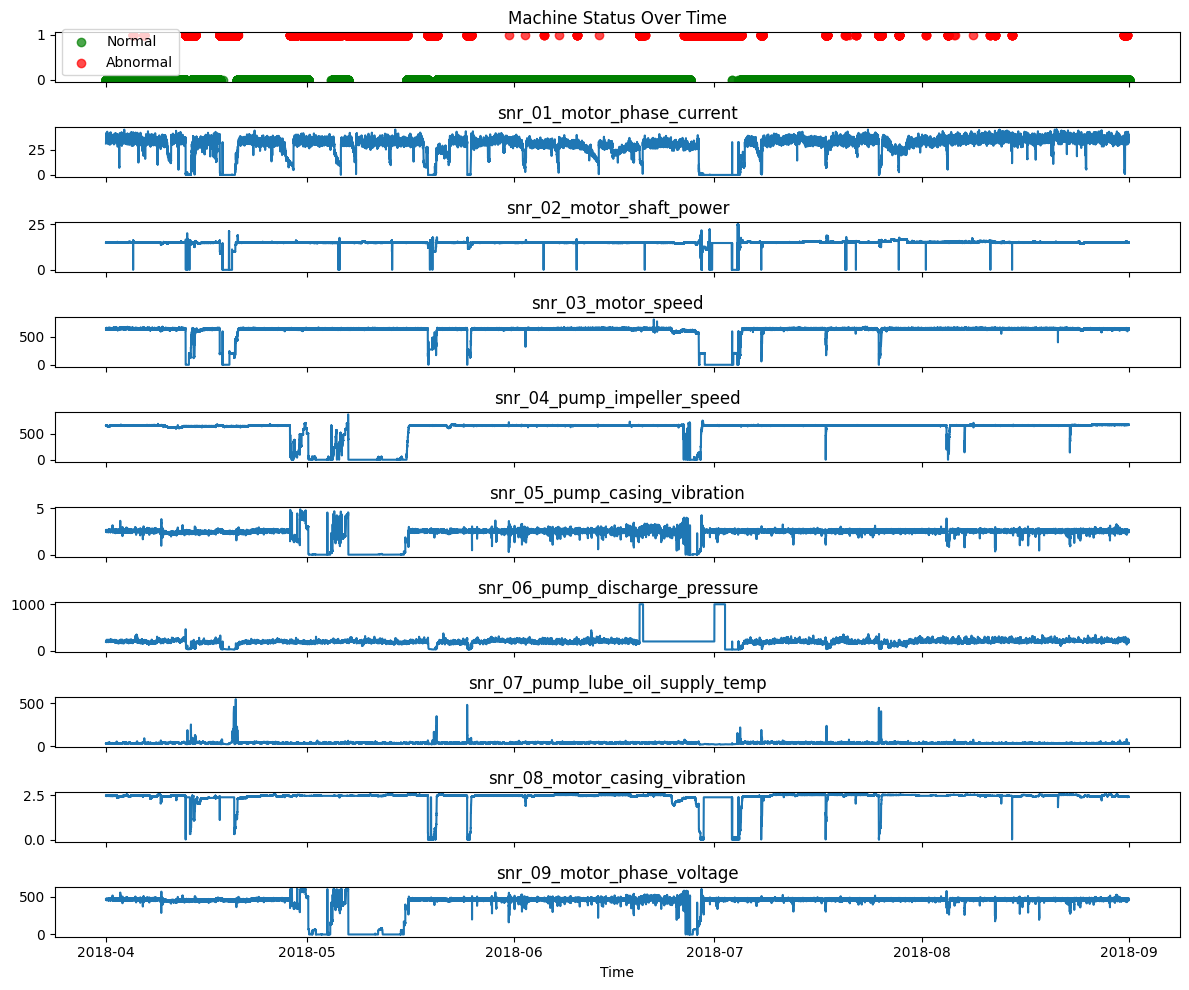

In [38]:
def plot_machine_status(df, selected_sensors):
    """
    Plots the machine status alongside selected sensor readings.
    - Normal: green at y=1
    - Abnormal: red at y=0
    """
    fig, axes = plt.subplots(len(selected_sensors) + 1, 1, figsize=(12, 10), sharex=True)

    # Separate Normal and Abnormal timestamps:
    normal_data = df[df["machine_status"] == "Normal"]
    abnormal_data = df[df["machine_status"] == "Abnormal"]

    # Plot machine status with separate y-values:
    axes[0].scatter(normal_data["timestamp"], [0] * len(normal_data), c="green", label="Normal", alpha=0.7)
    axes[0].scatter(abnormal_data["timestamp"], [1] * len(abnormal_data), c="red", label="Abnormal", alpha=0.7)
    axes[0].set_title("Machine Status Over Time")
    axes[0].set_yticks([0, 1])  # let's set clear labels for both Normal (1) and Abnormal (0)
    axes[0].legend()

    # Plot sensor data:
    for i, sensor in enumerate(selected_sensors):
        axes[i + 1].plot(df["timestamp"], df[sensor], label=sensor)
        axes[i + 1].set_title(sensor)

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

# Alright, now let's run the visualization:
plot_machine_status(df, selected_sensors)

**Summary highlights:**

* We cleaned up the machine status to just **Normal (Green) vs Abnormal (Red)** and that will keep things simple and clear.  
* Status now **actually reflects** sensor trends, when things spike, we see it in the status.  
* **No more weird transitions** (like skipping steps or looping between states).  

### **Machine Health Flags**<a id='Machine_Health_Flags'></a>
[Contents](#Contents)

When dealing with industrial machines, it's not just about knowing when something is completely broken—we also want to catch early warning signs. Instead of sifting through raw sensor data, we'll create clear yes/no flags to tell us when something is behaving abnormally.

* We'll use dynamic thresholds (based on statistical analysis) to set normal operating ranges for each sensor.
* If a sensor's value goes beyond this range, we flag it as 1 (Yes, abnormal).
* If it's within the expected limits, we flag it as 0 (No, normal).

In [39]:
# First let's compute the dynamic thresholds:
sensor_columns = [
    "snr_01_motor_phase_current",
    "snr_02_motor_shaft_power",
    "snr_03_motor_speed",
    "snr_04_pump_impeller_speed",
    "snr_05_pump_casing_vibration",
    "snr_06_pump_discharge_pressure",
    "snr_07_pump_lube_oil_supply_temp",
    "snr_08_motor_casing_vibration",
    "snr_09_motor_phase_voltage"
]

thresholds = calculate_dynamic_thresholds(df, sensor_columns, threshold=2.5)

# Then let's generate flags based on thresholds:
for sensor in sensor_columns:
    flag_col = f"{sensor}_flag"
    lower, upper = thresholds[sensor]["lower"], thresholds[sensor]["upper"]

    # Flag as 1 if the sensor value is outside the dynamic range:
    df[flag_col] = ((df[sensor] < lower) | (df[sensor] > upper)).astype(int)

# Alright finally, let's view the new columns:
df.head()


,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag
0,2018-04-01 00:00:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33,Normal,0,0,0,0,0,0,0,0,0
1,2018-04-01 00:01:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33,Normal,0,0,0,0,0,0,0,0,0
2,2018-04-01 00:02:00,32.09,15.01,638.89,666.22,2.50,203.70,31.25,2.44,459.64,Normal,0,0,0,0,0,0,0,0,0
3,2018-04-01 00:03:00,31.67,15.08,628.12,666.01,2.51,203.12,31.51,2.46,460.89,Normal,0,0,0,0,0,0,0,0,0
4,2018-04-01 00:04:00,31.95,15.08,636.46,663.21,2.60,201.39,31.51,2.45,468.22,Normal,0,0,0,0,0,0,0,0,0


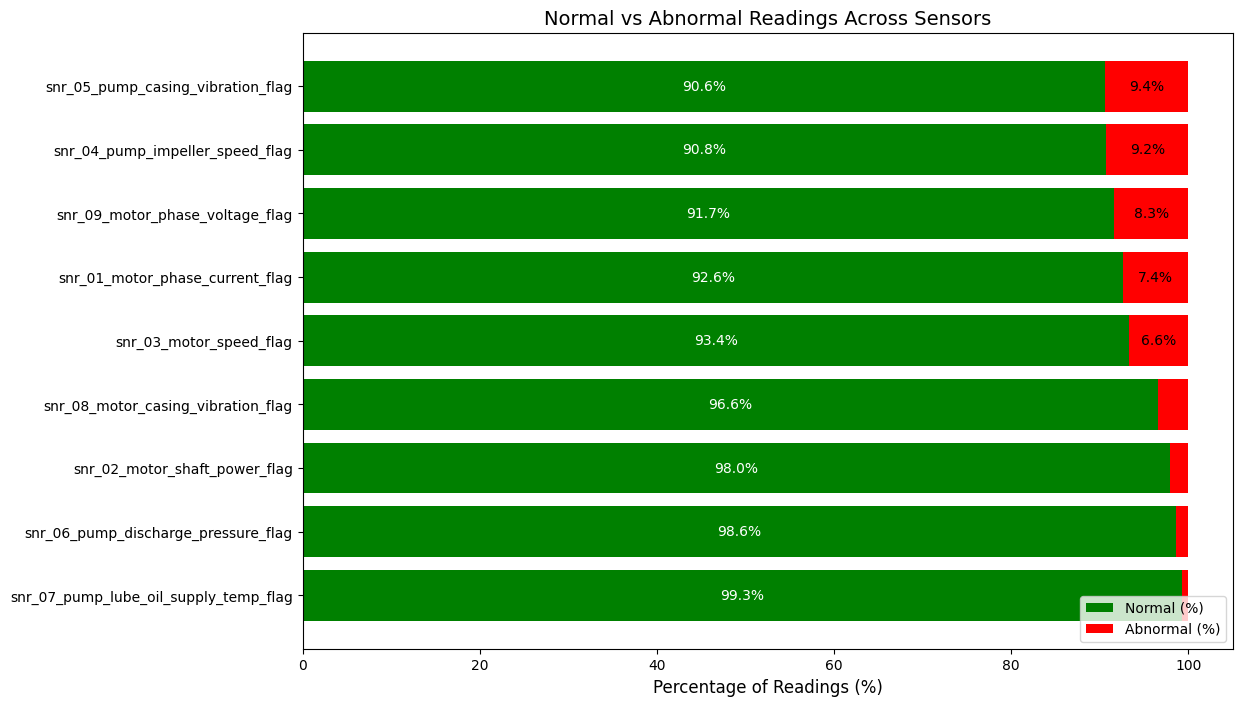

In [40]:
# First let's visualize all flags (Abnromal & Normal):
flag_columns = [col for col in df.columns if col.endswith("_flag")]

# Calculate normal and abnormal percentages:
total_counts = df[flag_columns].count()
abnormal_counts = (df[flag_columns] == 1).sum()
normal_counts = total_counts - abnormal_counts

abnormal_percentages = (abnormal_counts / total_counts) * 100
normal_percentages = (normal_counts / total_counts) * 100

# Sort sensors by highest abnormal percentage:
sorted_indices = abnormal_percentages.sort_values(ascending=False).index
abnormal_percentages = abnormal_percentages[sorted_indices]
normal_percentages = normal_percentages[sorted_indices]

# Plot stacked horizontal bar chart:
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.barh(sorted_indices, normal_percentages, color="green", label="Normal (%)")
bars2 = ax.barh(sorted_indices, abnormal_percentages, left=normal_percentages, color="red", label="Abnormal (%)")

# Add percentage labels inside bars:
for bars, color in zip([bars1, bars2], ["white", "black"]):
    for bar in bars:
        width = bar.get_width()  # Get bar length
        if width > 5:
            ax.text(
                bar.get_x() + width / 2,  # Center text horizontally
                bar.get_y() + bar.get_height() / 2,  # Center text vertically
                f"{width:.1f}%",  # Format as percentage
                ha="center", va="center", fontsize=10, color=color
            )

# Formatting:
ax.set_xlabel("Percentage of Readings (%)", fontsize=12)
ax.set_title("Normal vs Abnormal Readings Across Sensors", fontsize=14)
ax.legend(loc="lower right")
plt.gca().invert_yaxis()
plt.show()


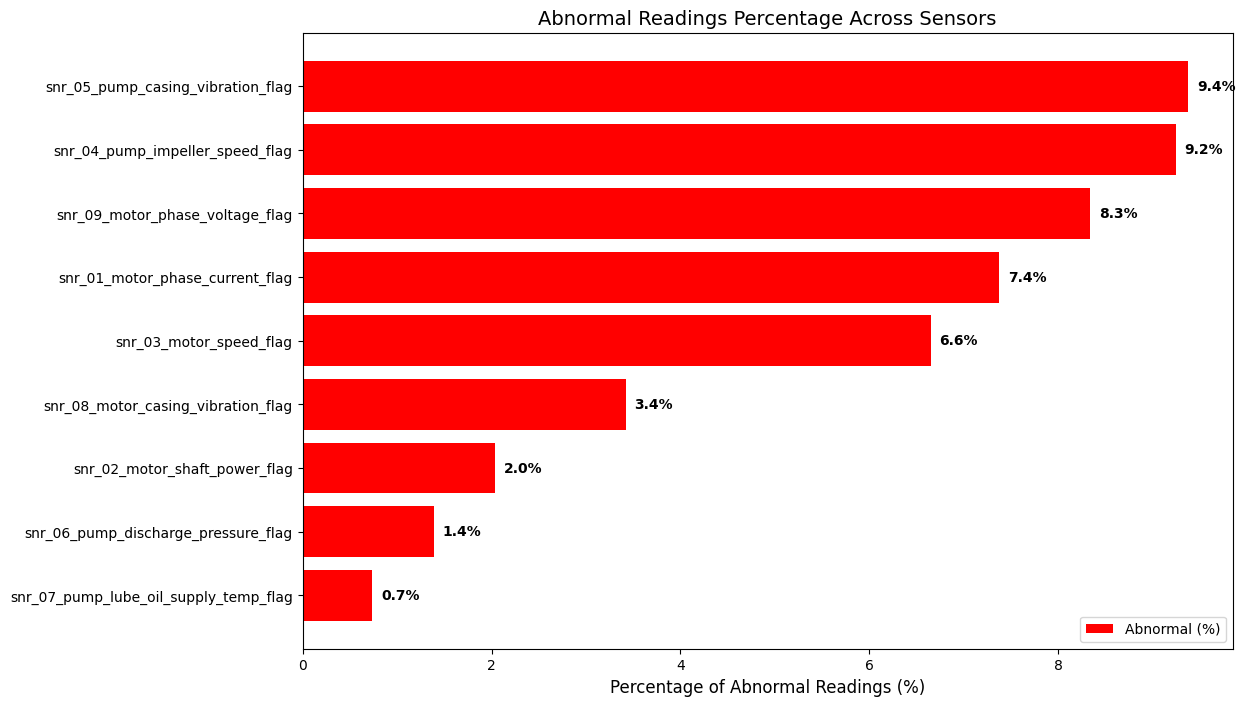

In [41]:
# For here, let's visualize all flags with abnormal status:
flag_columns = [col for col in df.columns if col.endswith("_flag")]

# Calculate abnormal percentages:
total_counts = df[flag_columns].count()
abnormal_counts = (df[flag_columns] == 1).sum()
abnormal_percentages = (abnormal_counts / total_counts) * 100

# Sort sensors by highest abnormal percentage:
sorted_indices = abnormal_percentages.sort_values(ascending=False).index
abnormal_percentages = abnormal_percentages[sorted_indices]

# Plot horizontal bar chart:
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(sorted_indices, abnormal_percentages, color="red", label="Abnormal (%)")

# Add labels inside bars:
for bar in bars:
    width = bar.get_width()
    text_position = width + 0.5
    text_color = "white" if width > 10 else "black"

    ax.text(
        max(text_position, 1.2),
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va="center", ha="right", fontsize=10, color=text_color, fontweight="bold"
    )

# Formatting:
ax.set_xlabel("Percentage of Abnormal Readings (%)", fontsize=12)
ax.set_title("Abnormal Readings Percentage Across Sensors", fontsize=14)
ax.legend(loc="lower right")
plt.gca().invert_yaxis()
plt.show()

### **Failure Category**<a id='Failure_Category'></a>
[Contents](#Contents)  

To make failure analysis more practical, we're grouping failures into **two  broad categories** instead of dealing with too many individual sensor issues. This keeps things **clear and actionable** while still giving us useful insights.  

**Categories Details:**  
* **Critical Failure**: Major issues, highest failure rates (>=8%)  
* **Moderate Failure**: Early warning signs, mid-range failure rates (less than 8%)  

This approach helps us **track overall machine health** without getting lost in sensor-level noise.


In [42]:
# First let's upper case machine_status:
df["machine_status"] = df["machine_status"].str.strip().str.upper()

# DThen let's define our logic for the failure categories based on abnormal percentages:
def categorize_failure(percentage):
    if percentage >= 8:
        return "critical_failure"
    else:
        return "moderate_failure"

# Get flag columns:
flag_columns = [col for col in df.columns if col.endswith("_flag")]

# Calculate abnormal percentages:
total_counts = df[flag_columns].count()
abnormal_counts = (df[flag_columns] == 1).sum()
abnormal_percentages = (abnormal_counts / total_counts) * 100

# Assign failure categories for each sensor:
failure_categories = abnormal_percentages.apply(categorize_failure)

# Function to determine failure cause for each row:
def assign_failure_cause(row):
    if row["machine_status"] == "NORMAL":
        return "no_failure"

    # Get sensors that are abnormal in this row:
    failed_sensors = [sensor for sensor in flag_columns if row[sensor] == 1]

    # Get failure categories for the failed sensors:
    failure_types = failure_categories[failed_sensors].unique()

    # Prioritize failures: Critical > Moderate:
    if "critical_failure" in failure_types:
        return "critical_failure"
    else:
        return "moderate_failure"

# Apply function to determine failure cause:
df["failure_category"] = df.apply(assign_failure_cause, axis=1)

# Display distribution of failure causes:
value_counts_with_percentage(df, 'failure_category')


,failure_category,Count,Percentage
0,no_failure,179916,81.66
1,critical_failure,21572,9.79
2,moderate_failure,18832,8.55


### **Failure Cause**<a id='Failure_Cause'></a>
[Contents](#Contents)

Now that we have a high-level failure category, let's take it a step further and pinpoint where the issue is happening. Instead of just saying "critical failure", we want to know if it's a motor issue, pump issue, electrical issue, or temperature issue:

* **Motor Issue:** If motor-related sensors show abnormalities
* **Pump Issue:** If pump-related sensors are failing
* **Electrical Issue:** If voltage or current sensors are outside thresholds
* **Temperature Issue:** If any temperature sensor exceeds limits
* If **multiple issues** occur at the same time, we'll list all of them ("Motor Issue, Electrical Issue" .. etc).

In [43]:
def classify_failure_cause(row):
    """
    Assigns failure causes based on which sensor flags are abnormal.
    If multiple failures occur, they are combined (Example: "Rotational Issue, Electrical Issue").
    """
    failure_causes = []

    # Rotational Issue (Motor & Pump Speed):
    motor_speed_flag = row["snr_03_motor_speed_flag"]
    pump_speed_flag = row["snr_04_pump_impeller_speed_flag"]

    if motor_speed_flag == 1 or pump_speed_flag == 1:
        failure_causes.append("rotational_issue")

    # Vibration Issue (Motor & Pump):
    if row["snr_08_motor_casing_vibration_flag"] == 1 or row["snr_05_pump_casing_vibration_flag"] == 1:
        failure_causes.append("vibration_issue")

    # Pressure Issue (Pump Discharge Pressure):
    if row["snr_06_pump_discharge_pressure_flag"] == 1:
        failure_causes.append("pressure_issue")

    # Temperature Issue (Lube Oil Supply Temperature):
    if row["snr_07_pump_lube_oil_supply_temp_flag"] == 1:
        failure_causes.append("temperature_ssue")

    # Electrical Issue (Motor Current, Shaft Power, Voltage):
    if (row["snr_01_motor_phase_current_flag"] == 1 or
        row["snr_02_motor_shaft_power_flag"] == 1 or
        row["snr_09_motor_phase_voltage_flag"] == 1):
        failure_causes.append("electrical_issue")

    # If machine is normal, mark it as no failure:
    if row["machine_status"] == "NORMAL":
        return "no_failure"

    # If no specific failure is detected, mark as unknown failure:
    return ", ".join(failure_causes) if failure_causes else "unknown_failure"

# Apply function to assign failure causes:
df["failure_cause"] = df.apply(classify_failure_cause, axis=1)

# Display distribution of failure causes:
value_counts_with_percentage(df, "failure_cause")


,failure_cause,Count,Percentage
0,no_failure,179916,81.66
1,"rotational_issue, vibration_issue, electrical_issue",21897,9.94
2,"rotational_issue, electrical_issue",7314,3.32
3,"rotational_issue, pressure_issue, electrical_issue",2304,1.05
4,"vibration_issue, electrical_issue",1920,0.87
5,vibration_issue,1655,0.75
6,"rotational_issue, vibration_issue",1612,0.73
7,rotational_issue,936,0.42
8,pressure_issue,758,0.34
9,"rotational_issue, temperature_ssue, electrical_issue",466,0.21


In [44]:
df.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag,failure_category,failure_cause
0,2018-04-01 00:00:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure
1,2018-04-01 00:01:00,31.12,15.05,634.38,665.40,2.57,201.39,31.51,2.47,466.33,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure
2,2018-04-01 00:02:00,32.09,15.01,638.89,666.22,2.50,203.70,31.25,2.44,459.64,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure
3,2018-04-01 00:03:00,31.67,15.08,628.12,666.01,2.51,203.12,31.51,2.46,460.89,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure
4,2018-04-01 00:04:00,31.95,15.08,636.46,663.21,2.60,201.39,31.51,2.45,468.22,NORMAL,0,0,0,0,0,0,0,0,0,no_failure,no_failure


### **Affected Sensors List**<a id='Affected_Sensors_List'></a>
[Contents](#Contents)

Now that we have broad failure categories, let's go one step further and list the exact sensors that triggered a failure:

* Instead of just saying "Rotational Issue", we'll show which specific speed sensors were impacted.
* This gives a detailed diagnostic view, making it easier to pinpoint the exact issue.
* If multiple sensors are abnormal, we'll list them all together in one column.

In [45]:
def list_faulty_sensors(row):
    """
    Identifies all sensors that are in an abnormal state and lists them.
    If no sensors are abnormal, it returns 'No faulty Sensors'.
    """
    faulty_sensors = []

    # Check each sensor flag:
    for sensor in flag_columns:
        if row[sensor] == 1:
            faulty_sensors.append(sensor.replace("_flag", ""))
    return ", ".join(faulty_sensors) if faulty_sensors else "no_faulty_sensors"

# Apply function to assign impacted sensors:
df["faulty_sensors"] = df.apply(list_faulty_sensors, axis=1)

# Display distribution of faulty sensors:
value_counts_with_percentage(df, "faulty_sensors")


,faulty_sensors,Count,Percentage
0,no_faulty_sensors,179916,81.66
1,"snr_04_pump_impeller_speed, snr_05_pump_casing_vibration, snr_09_motor_phase_voltage",18343,8.33
2,"snr_01_motor_phase_current, snr_03_motor_speed",4443,2.02
3,"snr_01_motor_phase_current, snr_02_motor_shaft_power, snr_03_motor_speed",2871,1.30
4,"snr_01_motor_phase_current, snr_03_motor_speed, snr_06_pump_discharge_pressure",2304,1.05
5,"snr_01_motor_phase_current, snr_08_motor_casing_vibration",1838,0.83
6,"snr_01_motor_phase_current, snr_03_motor_speed, snr_08_motor_casing_vibration",1824,0.83
7,"snr_01_motor_phase_current, snr_02_motor_shaft_power, snr_03_motor_speed, snr_08_motor_casing_vibration",1443,0.65
8,"snr_04_pump_impeller_speed, snr_05_pump_casing_vibration",1073,0.49
9,snr_05_pump_casing_vibration,908,0.41


In [46]:
df[df['machine_status'] == 'ABNORMAL'].head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,machine_status,snr_01_motor_phase_current_flag,snr_02_motor_shaft_power_flag,snr_03_motor_speed_flag,snr_04_pump_impeller_speed_flag,snr_05_pump_casing_vibration_flag,snr_06_pump_discharge_pressure_flag,snr_07_pump_lube_oil_supply_temp_flag,snr_08_motor_casing_vibration_flag,snr_09_motor_phase_voltage_flag,failure_category,failure_cause,faulty_sensors
5834,2018-04-05 01:14:00,37.93,0.01,627.08,665.45,2.55,194.16,30.99,2.45,463.48,ABNORMAL,0,1,0,0,0,0,0,0,0,moderate_failure,electrical_issue,snr_02_motor_shaft_power
5835,2018-04-05 01:15:00,37.79,0.01,636.57,664.32,2.61,193.87,30.47,2.46,469.45,ABNORMAL,0,1,0,0,0,0,0,0,0,moderate_failure,electrical_issue,snr_02_motor_shaft_power
5836,2018-04-05 01:16:00,38.40,0.01,649.54,666.69,2.49,193.87,30.21,2.45,458.82,ABNORMAL,0,1,0,0,0,0,0,0,0,moderate_failure,electrical_issue,snr_02_motor_shaft_power
5837,2018-04-05 01:17:00,38.43,0.01,643.17,667.05,2.60,193.87,29.69,2.46,466.61,ABNORMAL,0,1,0,0,0,0,0,0,0,moderate_failure,electrical_issue,snr_02_motor_shaft_power
5838,2018-04-05 01:18:00,39.24,0.01,638.77,667.12,2.52,192.13,28.91,2.44,462.78,ABNORMAL,0,1,0,0,0,0,0,0,0,moderate_failure,electrical_issue,snr_02_motor_shaft_power


## **Saving the clean dataset**<a id='Saving_dataset'></a>
[Contents](#Contents)

In [47]:
# Alright, let's save the DataFrame as a CSV file:
df.to_csv('/content/drive/My Drive/Colab Notebooks/sensor_clean_df.csv', index=False)

In [48]:
# Here's, let's call our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,datetime64[ns],0,0.00
snr_01_motor_phase_current,187145,float64,0,0.00
snr_02_motor_shaft_power,566,float64,0,0.00
snr_03_motor_speed,7845,float64,0,0.00
snr_04_pump_impeller_speed,100422,float64,0,0.00
snr_05_pump_casing_vibration,152604,float64,0,0.00
snr_06_pump_discharge_pressure,1109,float64,0,0.00
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.00
snr_08_motor_casing_vibration,1254,float64,0,0.00
snr_09_motor_phase_voltage,148001,float64,0,0.00
